# Discovering Liparulo and Shoemaker, 2024 model using Robinson et al., 2011 Dataset

In [1]:
#Import Generated Samples using Robinson et al., (2014) 
using CSV, DataFrames
using Pkg
using Random, Statistics

rng = Random.MersenneTwister(42)
project_root_dir = dirname(Pkg.project().path)

df_samples = CSV.read(
    joinpath(
        project_root_dir,
        "Results",
        "Robinson_train.csv"
        ),
    DataFrame
)

df_samples_female = CSV.read(
    joinpath(
        project_root_dir,
        "Results",
        "Robinson_train_female.csv"
        ),
    DataFrame
)

Y_train = permutedims(
    Matrix{Float32}(
        df_samples_female[
            :,
            [:Virus, :CCL2, Symbol("IL-6")]
        ]
    )
)

Y_train_std = vec(Statistics.std(Y_train; dims = 2))

t_train = permutedims(
    Matrix{Float32}(
        df_samples_female[
            :,
            [Symbol("Time (Days)")]
        ]
    )
)

1×40 Matrix{Float32}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  7.0  7.0  7.0  7.0  7.0  7.0  7.0

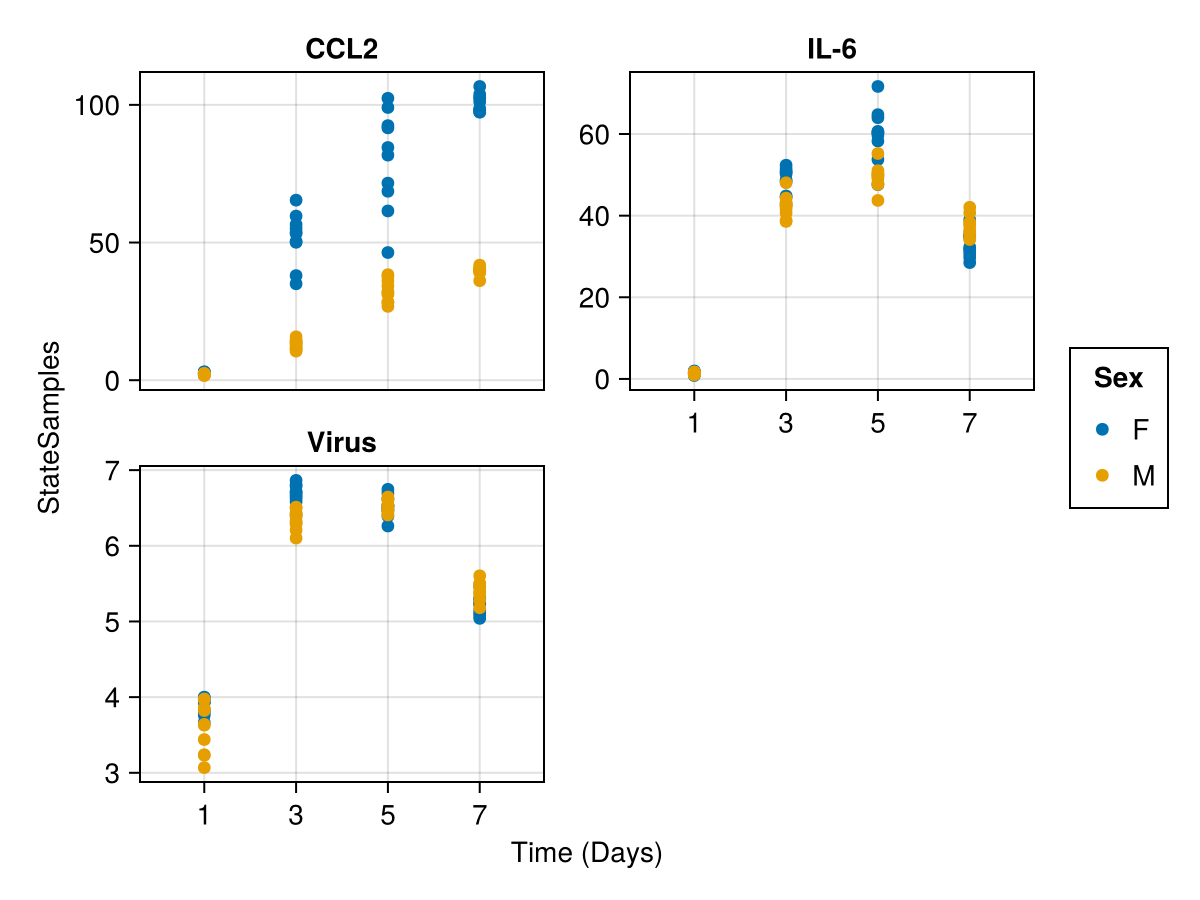

In [2]:
# Plot the generated data
using AlgebraOfGraphics, CairoMakie
fig = draw(
    AlgebraOfGraphics.data(
        df_samples 
    ) * 
    mapping(
        Symbol("Time (Days)") => string,
        :StateSamples,
        color = :Sex,
        layout = :State
    ) *
    visual(AlgebraOfGraphics.Scatter);
    facet=(; linkyaxes = :none)
)

# Creating an architecture and fitting the NN

The published model is as follows: 

\begin{align}
 &\frac{dV}{dt} = k \cdot V \cdot \left( 1 - \frac{V}{K}\right) - r_{v, ifn} \cdot IFN \cdot V - r_{v, M} \cdot V \cdot M - d_v \cdot V \\
&\frac{dIFN}{dt} = \frac{k_1 \cdot V^n}{k_2 + V^n} + r_{ifn, m} \cdot M - d_{ifn} \cdot IFN \\
&\frac{dM}{dt} = r_{M, ifn} \cdot IFN - d_{M} \cdot M \\
\end{align}


A reasonable set of assumptions behind known mechanisms can be-
- Virus experiences a logistic growth
- All states undergo first order degradation

Based on these assumptions, we can construct the following architecture-

\begin{align} 
&\frac{dV}{dt} = k \cdot V \cdot \left(1 - \frac{V}{K}\right) + g_{v}(t, \theta_g) - d_v \cdot V \\
&\frac{dIFN}{dt} = g_{ifn}(t, \theta_g) - d_{ifn} \cdot IFN \\
&\frac{dM}{dt} = g_{m}(t, \theta_g) - d_{M} \cdot M \\
\end{align}

where $g:\mathbb{R}\to\mathbb{R}^3,\quad t\mapsto g(t;\,\theta_g)$

In [81]:
using ComponentArrays
struct LiparuloKnownParams{T<:AbstractFloat}
    k::T
    K::T
    d_v::T
    d_ifn::T
    d_m::T
end

LiparuloKnownParams(nt::ComponentVector) = LiparuloKnownParams(nt.k, nt.K, nt.d_v, nt.d_ifn, nt.d_m)

function LiparuloArchitecture(
        y::AbstractMatrix{<:Real},
        g::AbstractMatrix{<:Real},
        p::LiparuloKnownParams,
    )
    # Sanity Checks
    @assert size(y,1) == 3 "y must have 3 states (V, IFN, M)"
    @assert size(g,1) == 3 "g must be 3xB"

    V, IFN, M = y

    function LogisticGrowthRate(
            x,
            growth_rate,
            carrying_capacity
            )
        growth_rate .* x .* (1 - x./carrying_capacity)
    end

    dV = LogisticGrowthRate(V, p.k, p.K) .+ g[1, :] .- p.d_v .* V
    dIFN = g[2, :] .- p.d_ifn .* IFN
    dM = g[3, :] .- p.d_m .* M
    
    return permutedims(hcat(dV, dIFN, dM))
end

LiparuloArchitecture (generic function with 1 method)

In [82]:
using Lux, NNlib 

State_MLP = Lux.Chain(
    Lux.Dense(1, 4, tanh),
    Lux.Dense(4, 3, NNlib.softplus)
)

ps_StateMLP, st_StateMLP = Lux.setup(rng, State_MLP)
g_MLP = Lux.Chain(
    Lux.Dense(1, 4, tanh),
    Lux.Dense(4, 3)
)
ps_gMLP, st_gMLP = Lux.setup(rng, g_MLP)

((layer_1 = (weight = Float32[-2.573412; 1.8518248; -0.7070789; -2.0560946;;], bias = Float32[-0.56014895, -0.1257, 0.47561717, 0.85903883]), layer_2 = (weight = Float32[0.057829123 0.017754918 0.18528317 0.13631725; -0.3877037 -0.68313324 0.77958417 0.113557555; 0.6742855 -0.298122 0.37650108 0.79777044], bias = Float32[0.061087847, 0.15258014, -0.34240532])), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [83]:
using Optimization, OptimizationOptimisers
using Zygote

# Create a dense t grid
t_dense = Float32.(range(0, 10, length=200) |> collect)
t_dense = permutedims(t_dense)

# t_span to incorporate information at t = 0
t_span = [0f0, Float32.(t_train[end])]

# Initial Conditions

y0_init = Float32.([0.1, 1, 1])

# guess values for known physics
guess_Liparuloparams = LiparuloKnownParams(
    50f0,
    1000f0,
    1f0,
    1f0,
    1f0
)

LiparuloKnownParams{Float32}(50.0f0, 1000.0f0, 1.0f0, 1.0f0, 1.0f0)

In [136]:
λ_ic  = 1.0f0 * 5
λ_ode = 25.0f0
λ_Data = 1.0f0
λ_L1 = Float32(1e-3)

0.001f0

In [137]:
trainable_params = ComponentArrays.ComponentArray(
    StateMLP = ps_StateMLP,
    gMLP     = ps_gMLP,
    ODE_par  = (
        k = guess_Liparuloparams.k,
        K = guess_Liparuloparams.K,
        d_v = guess_Liparuloparams.d_v,
        d_ifn = guess_Liparuloparams.d_ifn,
        d_m = guess_Liparuloparams.d_m
        ),
    # hyperparams = (λ_ode = λ_ode, λ_Data = λ_Data)
)

MSE(ŷ, y) = Statistics.mean(abs2, vec(ŷ .- y))

function MSE(ŷ, y, denom)  # normalized MSE
    t = vec((ŷ .- y) ./ denom)
    Statistics.mean(abs2, t)
end

#--------Training--------

ctx_stage1 = (
    State_MLP   = State_MLP,
    st_StateMLP = st_StateMLP,
    t_train     = t_train,
    Y_train     = Y_train,
    Y_train_std = Y_train_std,
    y0_obs      = y0_init,
    λ_ic        = λ_ic,
    λ_Data      = λ_Data,
    λ_ode       = λ_ode,
    λ_L1       = λ_L1,
    t_span      = t_span
)

ctx_stage2 = (
    State_MLP   = State_MLP,
    st_StateMLP = st_StateMLP,
    g_MLP       = g_MLP,
    st_gMLP     = st_gMLP,
    t_train     = t_train,
    Y_train     = Y_train,
    Y_train_std = Y_train_std,
    y0_obs      = y0_init,
    λ_ic        = λ_ic,
    λ_Data      = λ_Data,
    λ_ode       = λ_ode,
    λ_L1       = λ_L1,
    t_dense     = t_dense,
    t_span      = t_span,
    ODE_par_bounds = (
        k = [1f0, 100f0],
        K = [1f0, 2000f0],
        d_v = Float32.([1e-05, 10]),
        d_ifn = Float32.([1e-03, 1000]),
        d_m = Float32.([1e-03, 100]),
    )
)

println(size(trainable_params))

(51,)


In [138]:
# Supervised loss (fit to data)
function l1_penalty(ps)
    w1 = ComponentArrays.getdata(ps.StateMLP)
    # w2 = ComponentArrays.getdata(ps.gMLP)
    return sum(abs, w1) # + sum(abs, w2)
end

function loss_supervised(ps, ctx)
    smodel = Lux.StatefulLuxLayer(ctx.State_MLP, ps.StateMLP, ctx.st_StateMLP)
    ŷ = smodel(ctx.t_train)
    data_mse = MSE(ŷ, ctx.Y_train, ctx.Y_train_std)
    ic_mse   = MSE(smodel([ctx.t_span[1]]'), ctx.y0_obs, ctx.Y_train_std)
    reg_loss = ctx.λ_L1 * l1_penalty(ps)
    return ctx.λ_Data*data_mse*10 + ctx.λ_ic * ic_mse + reg_loss
end

using ForwardDiff

# 3×B Jacobian of smodel wrt scalar time, computed columnwise
dNNdt_fd(smodel, tvec::AbstractVector) = begin
    cols = map(tn -> begin
        J = Zygote.forwarddiff(x -> smodel(reshape(x, 1, :)), [tn])  # 3×1
        vec(J)  # 3
    end, tvec)
    reduce(hcat, cols)  # 3×B
end


dist_outside(x, lower, upper) = sum(@. max(0f0, lower - x) + max(0f0, x - upper))

function bound_loss(ps, ctx; scale=1000f0)
    p = ps.ODE_par
    b = ctx.ODE_par_bounds
    keys = propertynames(b)  # must match p

    # This is shorthand for mapreduce(f, +, keys) where f is the stuff inside the do block
    
    total = mapreduce(+, keys) do k
        x = getproperty(p, k)
        lo, hi = getproperty(b, k)  # b.k is a 2-element container
        dist_outside(x, lo, hi)
    end

    # We know that IFN and M production rates cannot be negative at the start
    gmodel = Lux.StatefulLuxLayer(ctx.g_MLP,     ps.gMLP,     ctx.st_gMLP)
    ystart = gmodel(ctx.t_dense[:, 1:50])
    #
    neg_penalty = sum( NNlib.relu.(-ystart[2:3, :]).^2 )
    
    return scale .* (total + neg_penalty)
end

# ODE-regularized loss (data + residual + IC)
function loss_unsupervised(ps, ctx, architecture, ODE_params, bound_loss_function::Function=bound_loss)
    smodel = Lux.StatefulLuxLayer(ctx.State_MLP, ps.StateMLP, ctx.st_StateMLP)
    gmodel = Lux.StatefulLuxLayer(ctx.g_MLP,     ps.gMLP,     ctx.st_gMLP)

    # par = ps.ODE_par
    ODE_par = ODE_params(ps.ODE_par)

    Tdense = ctx.t_dense  # 1xN Matrix for now

    dNNdt = dNNdt_fd(smodel, vec(Tdense))         # 3×B
    f_ŷ   = architecture(smodel(Tdense), gmodel(Tdense), ODE_par)

    # ode_mse  = MSE(dNNdt, f_ŷ, ctx.Y_train_std)
    ode_mse  = MSE(dNNdt, f_ŷ, std(dNNdt))
    data_mse = MSE(smodel(ctx.t_train), ctx.Y_train, ctx.Y_train_std)
    ic_mse   = MSE(smodel([ctx.t_span[1]]'), ctx.y0_obs, ctx.Y_train_std)

    bl = ctx.λ_Data * data_mse
    bl2 = ctx.λ_ode * ode_mse
    reg_loss = ctx.λ_L1 * l1_penalty(ps)
    return bl + bl2 + ctx.λ_ic * ic_mse + bound_loss_function(ps, ctx) + reg_loss
end

loss_unsupervised (generic function with 2 methods)

In [139]:
# Add a Callback to monitor progress. 
# Callbacks are functions that the optimizer runs every n iterations

function metrics_stage2(ps, ctx, architecture, ODE_params)
    smodel = Lux.StatefulLuxLayer(ctx.State_MLP, ps.StateMLP, ctx.st_StateMLP)
    gmodel = Lux.StatefulLuxLayer(ctx.g_MLP,     ps.gMLP,     ctx.st_gMLP)

    # data MSE
    data_mse = MSE(smodel(ctx.t_train), ctx.Y_train, ctx.Y_train_std)

    # ODE MSE
    ODE_par = ODE_params(ps.ODE_par)
    Tdense  = ctx.t_dense
    dNNdt   = dNNdt_fd(smodel, vec(Tdense))
    f_ŷ     = architecture(smodel(Tdense), gmodel(Tdense), ODE_par)
    ode_mse = MSE(dNNdt, f_ŷ, ctx.Y_train_std)

    # activity of g
    g_out   = gmodel(Tdense)              # size: 3 × B (I assume)
    g_std   = std(vec(g_out))            # std over all components and times

    return data_mse, ode_mse, g_std
end

data_mse_hist = Float32[]
ode_mse_hist  = Float32[]
g_std_hist    = Float32[]

iter_hist     = Int[]
iter_counter  = Ref(0)

callback = function (state, l)
    iter_counter[] += 1

    # maybe record every N steps to keep arrays small
    N = 100
    if iter_counter[] % N == 0
        ps = state.u
        d_mse, o_mse, g_s = metrics_stage2(ps, ctx_stage2, LiparuloArchitecture, LiparuloKnownParams)

        push!(iter_hist, iter_counter[])
        push!(data_mse_hist, d_mse)
        push!(ode_mse_hist, o_mse)
        push!(g_std_hist, g_s)
    end

    return false  # don't stop optimization
end


#185 (generic function with 1 method)

In [140]:
# Zygote.jacobian(x -> loss_unsupervised(x, ctx_stage2, LiparuloArchitecture, LiparuloKnownParams), trainable_params)[1]

In [141]:
optfun1 = Optimization.OptimizationFunction(
    (θ, p) -> loss_supervised(θ, p),
    Optimization.AutoZygote()
)

prob1 = Optimization.OptimizationProblem(
    optfun1, 
    trainable_params, 
    ctx_stage1
)
res1 = Optimization.solve(
    prob1,
    OptimizationOptimisers.Adam(1e-03);
    maxiters = 10_000,
    callback = callback
)

trainable_params_post_stage1 = res1.u

ComponentVector{Float32}(StateMLP = (layer_1 = (weight = Float32[-2.42036; 2.1741943; 3.8226562; -2.4837341;;], bias = Float32[3.8520641, -2.0922525, -2.0357485, 3.9373379]), layer_2 = (weight = Float32[-0.17689875 1.4613662 2.1831853 -0.2588049; -9.01344 9.309737 10.137355 -9.649054; -8.672524 8.109323 8.085548 -8.421251], bias = Float32[2.0607576, 9.372155, 8.865059])), gMLP = (layer_1 = (weight = Float32[-2.573412; 1.8518248; -0.7070789; -2.0560946;;], bias = Float32[-0.56014895, -0.1257, 0.47561717, 0.85903883]), layer_2 = (weight = Float32[0.057829123 0.017754918 0.18528317 0.13631725; -0.3877037 -0.68313324 0.77958417 0.113557555; 0.6742855 -0.298122 0.37650108 0.79777044], bias = Float32[0.061087847, 0.15258014, -0.34240532])), ODE_par = (k = 50.0f0, K = 1000.0f0, d_v = 1.0f0, d_ifn = 1.0f0, d_m = 1.0f0))

In [142]:
loss_closure = (x, p) -> loss_unsupervised(x, p, LiparuloArchitecture, LiparuloKnownParams)

optfun2 = Optimization.OptimizationFunction(
    (θ, p) -> loss_closure(θ, p),
    Optimization.AutoZygote()
)

prob2 = Optimization.OptimizationProblem(
    optfun2,
    trainable_params_post_stage1, 
    ctx_stage2
)

res2 = Optimization.solve(
    prob2, 
    OptimizationOptimisers.Adam(5e-04); 
    maxiters=50_000,
    callback = callback
)
ps_trained = res2.u

ComponentVector{Float32}(StateMLP = (layer_1 = (weight = Float32[-1.2723687; 0.5397039; 1.1365702; -0.7940686;;], bias = Float32[7.7069597, -1.3123916, -0.57596564, 1.5085076]), layer_2 = (weight = Float32[0.77197933 -0.09900588 5.9543767 -0.00014698868; -4.5768476 31.12448 13.75059 -30.823616; 12.972567 0.00054561027 14.150259 -30.675583], bias = Float32[-2.2101267f-5, 12.259695, 0.0006950119])), gMLP = (layer_1 = (weight = Float32[-0.4274276; 0.96651006; 0.35636148; -2.4754868;;], bias = Float32[0.10705284, -1.9678211, 2.4378457, 6.797302]), layer_2 = (weight = Float32[-4.6699862 2.4468534 0.07507394 2.4422908; -15.523939 13.462062 14.670255 -13.892839; -8.769533 9.805191 10.509197 -5.6315794], bias = Float32[-3.1896615, 14.047964, 9.122355])), ODE_par = (k = 47.045326f0, K = 999.90497f0, d_v = 3.9552188f0, d_ifn = 0.9998966f0, d_m = 0.016598577f0))

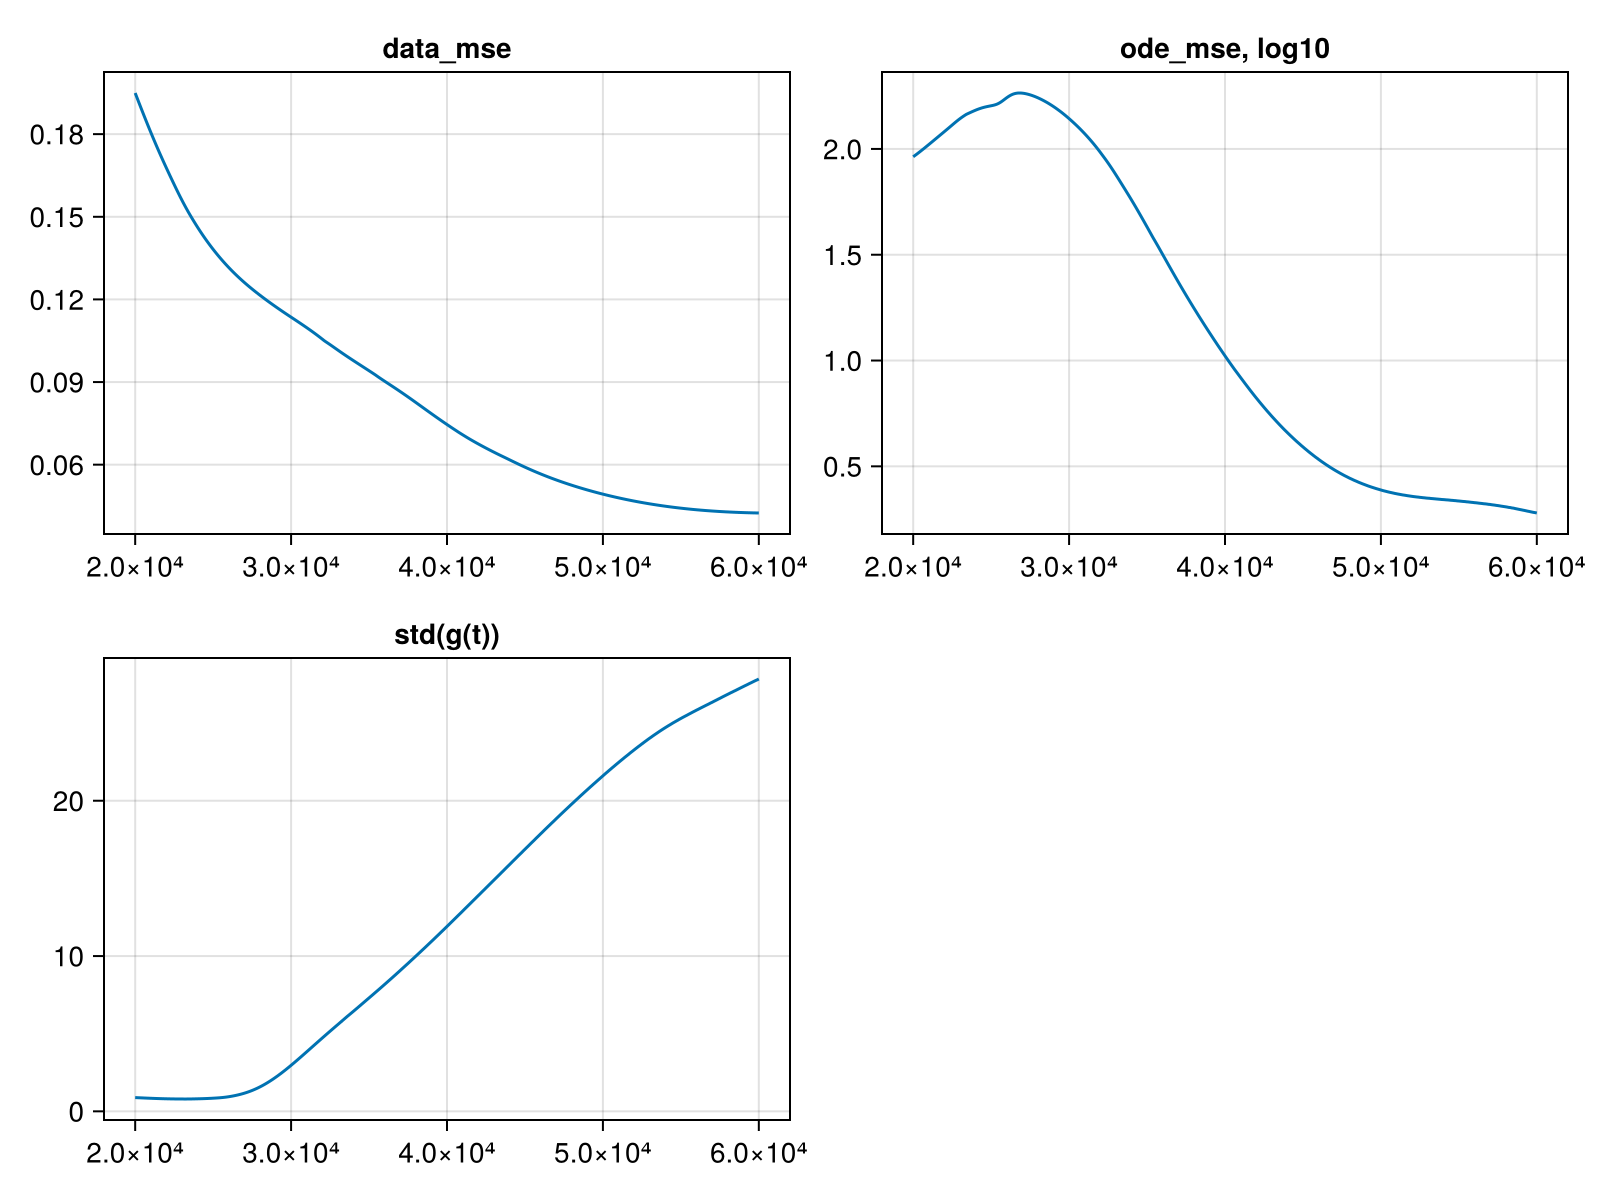

In [143]:
fig = CairoMakie.Figure(size = (800, 600))
ax1 = CairoMakie.Axis(fig[1,1]; title = "data_mse")
ax2 = CairoMakie.Axis(fig[1,2]; title = "ode_mse, log10")
ax3 = CairoMakie.Axis(fig[2,1]; title = "std(g(t))")
lines!(ax1, iter_hist[200:end], data_mse_hist[200:end], label="data_mse")
lines!(ax2, iter_hist[200:end], ode_mse_hist[200:end],  label="ode_mse, log10")
lines!(ax3, iter_hist[200:end], g_std_hist[200:end],    label="std(g(t))")  

fig


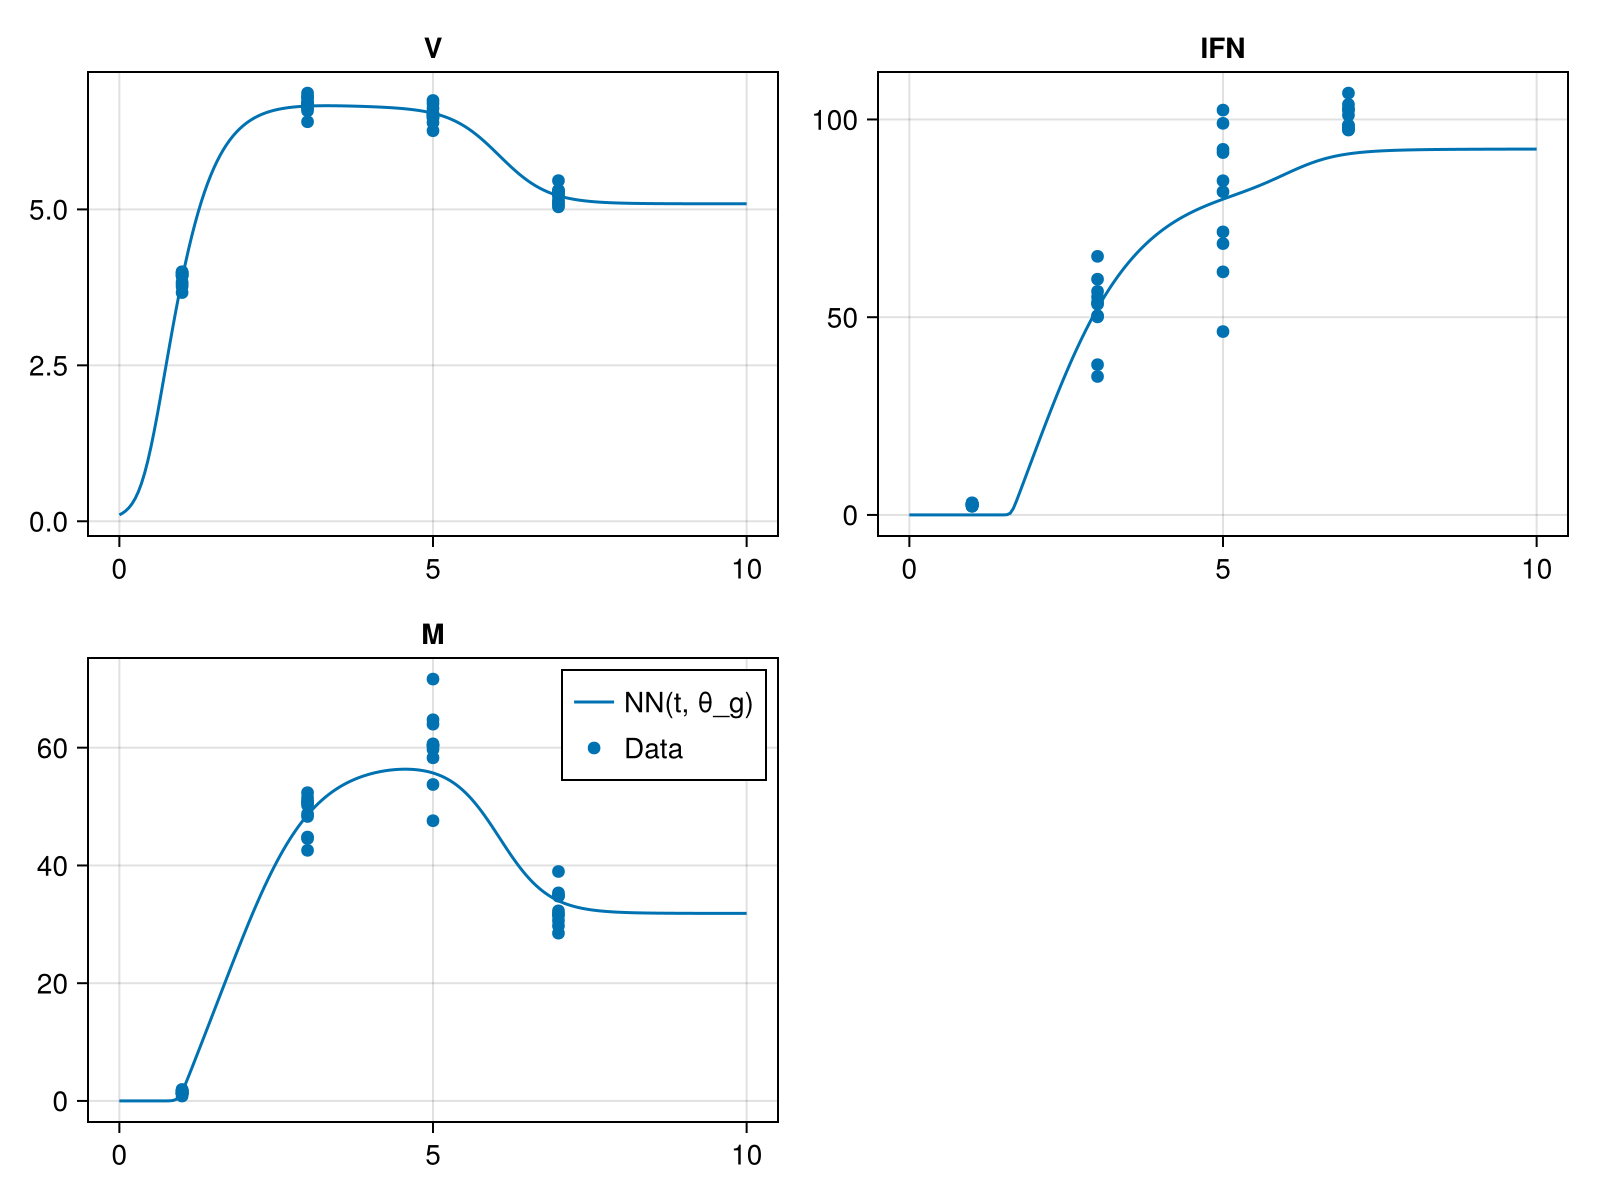

In [144]:
# Evaluate the model
smodel = Lux.StatefulLuxLayer(State_MLP, ps_trained.StateMLP, st_StateMLP)
t_plot = Float32.(range(first(t_span), 10, length=200) |> collect)
t_plot = permutedims(t_plot)

tvec = vec(t_plot)  
sŷ = smodel(t_plot)  # Should return an array of size (3, length(tvec))
# Create figure and axes
fig = CairoMakie.Figure(size = (800, 600))

ax1 = CairoMakie.Axis(fig[1, 1]; title = "V")
ax2 = CairoMakie.Axis(fig[1, 2]; title = "IFN")
ax3 = CairoMakie.Axis(fig[2, 1]; title = "M")

# Plot each component explicitly
CairoMakie.lines!(ax1, tvec, sŷ[1, :], label ="NN(t, θ_g)")
CairoMakie.scatter!(ax1, vec(t_train), Y_train[1, :], label ="Data")
CairoMakie.lines!(ax2, tvec, sŷ[2, :], label ="NN(t, θ_g)")
CairoMakie.scatter!(ax2, vec(t_train), Y_train[2, :], label ="Data")
CairoMakie.lines!(ax3, tvec, sŷ[3, :], label ="NN(t, θ_g)")
CairoMakie.scatter!(ax3, vec(t_train), Y_train[3, :], label ="Data")
# # Add legends (optional)
# CairoMakie.axislegend(ax1)
# CairoMakie.axislegend(ax2)
CairoMakie.axislegend(ax3)

# Display the figure
fig


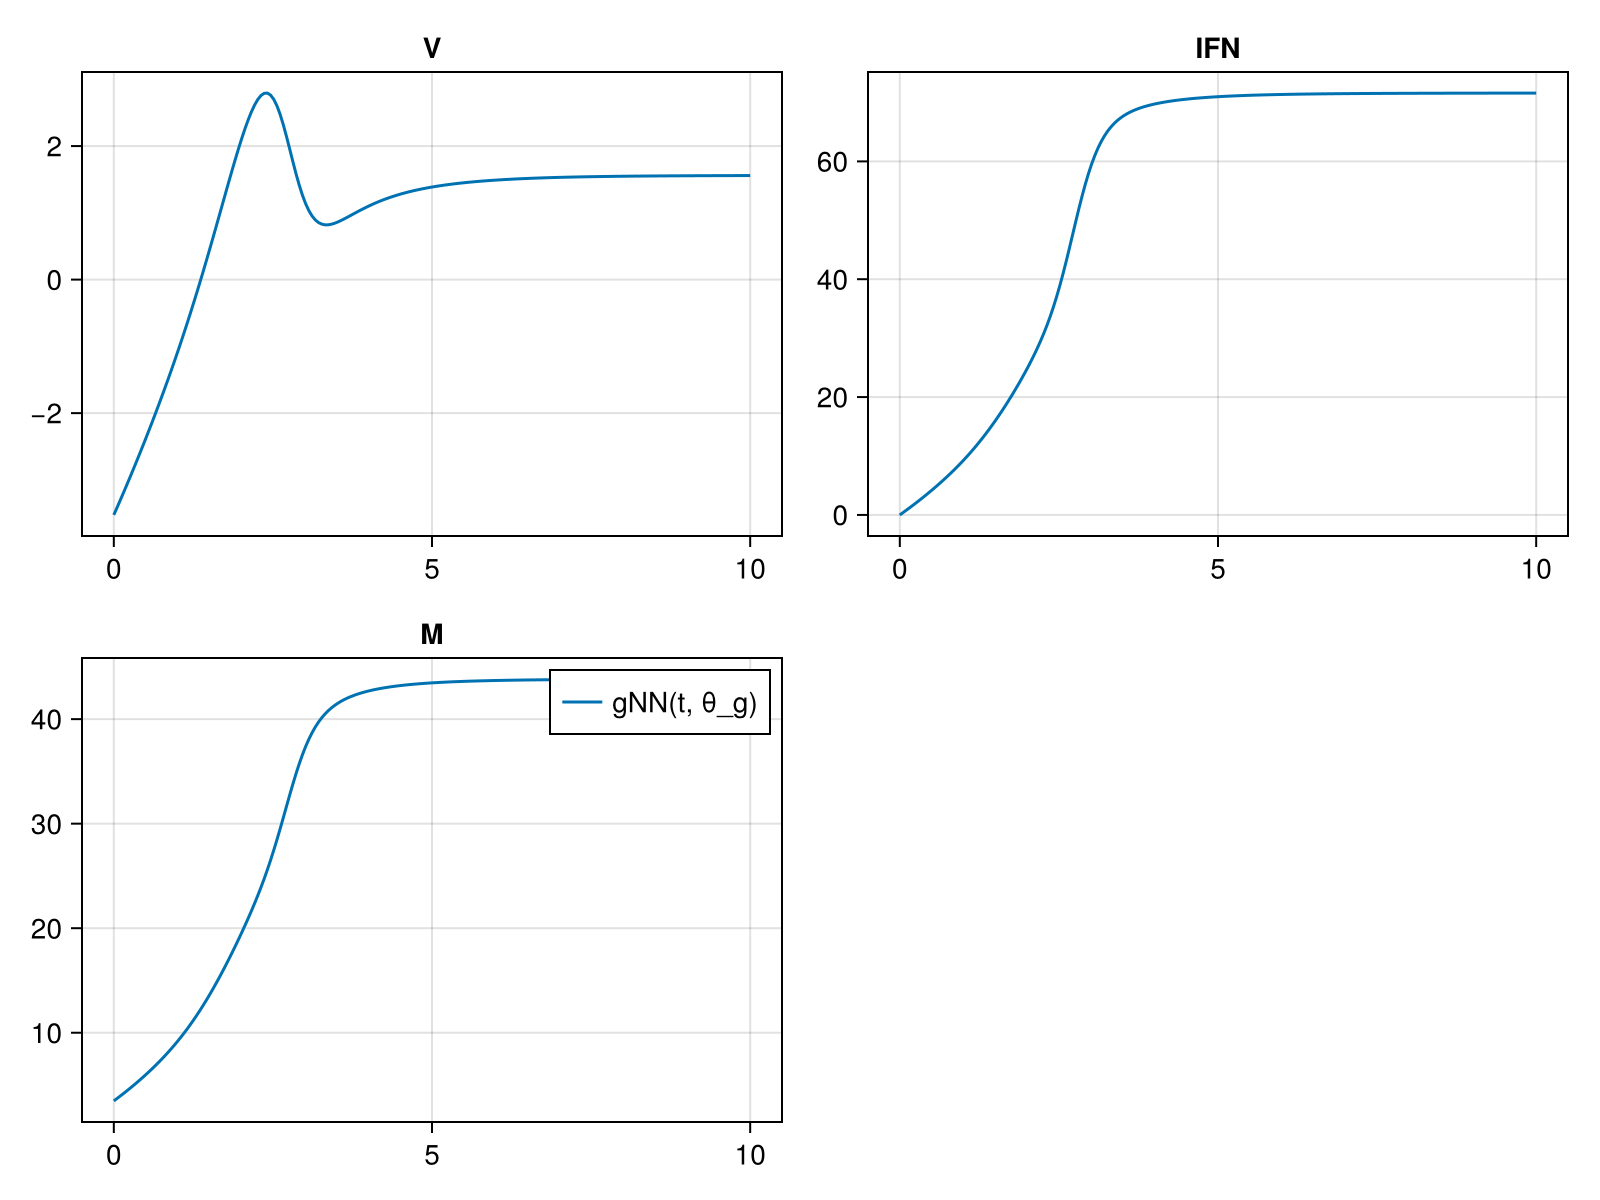

In [145]:
# Evaluate the model
gmodel = Lux.StatefulLuxLayer(g_MLP, ps_trained.gMLP, st_gMLP)
t_plot = Float32.(range(first(t_span), 10, length=200) |> collect)
t_plot = permutedims(t_plot)

tvec = vec(t_plot)  
gŷ = gmodel(t_plot)  # Should return an array of size (3, length(tvec))
# Create figure and axes
fig = CairoMakie.Figure(size = (800, 600))

ax1 = CairoMakie.Axis(fig[1, 1]; title = "V")
ax2 = CairoMakie.Axis(fig[1, 2]; title = "IFN")
ax3 = CairoMakie.Axis(fig[2, 1]; title = "M")

# Plot each component explicitly
CairoMakie.lines!(ax1, tvec, gŷ[1, :], label ="gNN(t, θ_g)")
# CairoMakie.scatter!(ax1, vec(t_train), Y_train[1, :], label ="Data")
CairoMakie.lines!(ax2, tvec, gŷ[2, :], label ="gNN(t, θ_g)")
# CairoMakie.scatter!(ax2, vec(t_train), Y_train[2, :], label ="Data")
CairoMakie.lines!(ax3, tvec, gŷ[3, :], label ="gNN(t, θ_g)")
# CairoMakie.scatter!(ax3, vec(t_train), Y_train[3, :], label ="Data")
# # Add legends (optional)
# CairoMakie.axislegend(ax1)
# CairoMakie.axislegend(ax2)
CairoMakie.axislegend(ax3)

# Display the figure
fig


In [149]:
using SymbolicRegression

t_symbolic = permutedims(Float32.(collect(range(t_span[1], t_span[2], length=1000))))
ŷ_symbolic = smodel(t_symbolic)
ĝ_symbolic = gmodel(t_symbolic)

dŷ_symbolicdt = reduce(hcat, [Zygote.jacobian(smodel, [τ])[1] for τ in t_symbolic])

3×1000 Matrix{Float32}:
 0.475168     0.494313     0.514257     …  -0.308668  -0.304145  -0.299672
 5.08027f-23  5.89632f-23  6.85106f-23      2.34653    2.31571    2.28523
 3.69202f-9   4.17043f-9   4.71517f-9      -5.15905   -5.0832    -5.00821

In [150]:

gV  = ĝ_symbolic[1, :]                                   
gIFN  = ĝ_symbolic[2, :]
gM  = ĝ_symbolic[3, :]

# Only +, -, * (no division/exp/log), modest size/parsimonious search
opts = SymbolicRegression.Options(
    binary_operators = [+, -, *],
    unary_operators  = [],   # no unary ops
    populations      = 20,
    maxsize          = 18,    # keep small; increase if underfitting
    parsimony        = 1e-4,  # nudge toward simpler formulas
    verbosity        = 1
)

varnames = ["V","IFN","M"]

function fit_one_rhs(X, y, opts, varnames; iters=400)
    hof = SymbolicRegression.equation_search(
        X, y;
        niterations = iters,
        options     = opts,
        variable_names = varnames,
        parallelism = :serial,
        progress= false
    )
    pareto = SymbolicRegression.calculate_pareto_frontier(hof)
    best   = pareto[end]  # simplest good model is near the end; pick as you like
    expr_str = SymbolicRegression.string_tree(best.tree, opts)
    return (best=best, pareto=pareto, expr_str=expr_str)
end

resS = fit_one_rhs(ŷ_symbolic, gV, opts, varnames; iters=500)
resI = fit_one_rhs(ŷ_symbolic, gIFN, opts, varnames; iters=500)
resR = fit_one_rhs(ŷ_symbolic, gM, opts, varnames; iters=500)

println("gV ≈ ", resS.expr_str)
println("gIFN ≈ ", resI.expr_str)
println("gM ≈ ", resR.expr_str)

[ Info: Started!



Expressions evaluated per second: 3.990e+04
Progress: 232 / 10000 total iterations (2.320%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.161e+00  0.000e+00  y = 0.79049
3           5.338e-01  6.993e-01  y = V - 4.7211
5           3.370e-01  2.299e-01  y = (V * 0.75272) + -3.3582
7           3.370e-01  -0.000e+00  y = ((V * 0.75275) + -1.6348) - 1.7236
9           3.370e-01  -0.000e+00  y = (((V * 0.75273) + M) - M) - 3.3583
11          3.256e-01  1.714e-02  y = (0.18819 - ((V + (IFN * 0.0053163)) + -4.4748)) * -0.7...
                                      0927
13          3.256e-01  5.960e-08  y = (0.18819 - (V + (((IFN + 0.0053163) * 0.0053163) + -4....
                                      4748))) * -0.70927
17          2.819e-01  3.604e-02  y = ((M * -0.033034) + (-5.3532 

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!



Expressions evaluated per second: 4.220e+04
Progress: 242 / 10000 total iterations (2.420%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.071e+02  0.000e+00  y = IFN
3           6.953e+01  2.161e-01  y = IFN * 0.89958
5           2.563e+01  4.990e-01  y = 0.57851 * (IFN + M)
7           1.143e+01  4.035e-01  y = (3.0353 * V) + (IFN * 0.65986)
9           1.019e+01  5.748e-02  y = ((V * 3.0353) + (IFN * 0.65986)) + -1.1143
11          7.315e+00  1.658e-01  y = -2.8764 - ((-8.5216 - (IFN * 0.53058)) - (M * 0.45218)...
                                      )
13          6.197e+00  8.291e-02  y = (((IFN * 0.55429) + V) - -0.8839) + ((M * 0.34181) - -...
                                      2.0753)
15          6.131e+00  5.340e-03  y = ((IFN + 32.184) * ((V + ((V * -0.92631) - 1.0

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!



Expressions evaluated per second: 3.960e+04
Progress: 234 / 10000 total iterations (2.340%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.073e+01  0.000e+00  y = M
3           3.593e+01  4.632e-01  y = M * 0.82166
5           1.058e+01  6.113e-01  y = (IFN * 0.4128) + 10.658
7           2.014e+00  8.293e-01  y = ((M + IFN) * 0.27738) - -7.347
9           2.013e+00  3.660e-04  y = (M * 0.28099) - ((IFN * -0.27539) - 7.3148)
11          1.134e+00  2.870e-01  y = ((IFN * 0.29911) - ((M * -0.17062) - V)) - -4.6286
13          1.134e+00  -0.000e+00  y = ((((IFN * -0.99628) + (M * -0.5683)) * -0.30023) + 4....
                                       6286) + V
───────────────────────────────────────────────────────────────────────────────────────────────────
══════════════════════════

[ Info: Final population:
[ Info: Results saved to:
